# Memoría Caché y Rendimiento

In [22]:
import numba 
from numba import jit, njit
import numpy as np
import time

In [23]:
# Medición de tiempos

class Timer:

    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start

## Sumar los elementos de una matriz

En este ejercicio, vamos a comprobar de manera empírica como el patrón de acceso a los datos puede mejorar el aprovechamiento de las memorias caché del sistema. Para ello, se utilizarán los dos funciones para sumar todos los elementos de una matriz, empleando un patrón de acceso diferente.

In [24]:
# Funciones de suma de elementos de matriz

@jit(nopython=True)
def slow(mat):
    """Sum all matrix values."""
    value = 0
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            value += mat[j, i]

    return value

@jit(nopython=True)
def fast(mat):
    """Sum all matrix values."""
    value = 0
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            value += mat[i, j]

    return value

In [25]:
# Comparamos contra numpy para confirmar que ambas son correctas
matrix = np.random.rand(10, 10)

# Numpy
print("--- Numpy ---")
print(matrix.sum())
print("")

# Python
print("--- Python ---")
print(slow.py_func(matrix))
print("")
print(fast.py_func(matrix))
print("")

#np.testing.assert_array_equal(slow.py_func(matrix), matrix.sum())
#np.testing.assert_array_equal(fast.py_func(matrix), matrix.sum())

# Numba
print("--- Numba ---")
print(slow(matrix))
print("")
print(fast(matrix))

#np.testing.assert_array_equal(slow(matrix), matrix.sum())
#np.testing.assert_array_equal(fast(matrix), matrix.sum())

--- Numpy ---
49.54404983266819

--- Python ---
49.544049832668215

49.54404983266819

--- Numba ---
49.544049832668215

49.54404983266819


Slow - Size 1000 Time 0.06132984161376953
Fast - Size 1000 Time 0.05902266502380371
Slow - Size 2000 Time 0.24429106712341309
Fast - Size 2000 Time 0.24255108833312988
Slow - Size 3000 Time 0.5513091087341309
Fast - Size 3000 Time 0.5390939712524414
Slow - Size 4000 Time 0.9804902076721191
Fast - Size 4000 Time 0.9470570087432861
Slow - Size 5000 Time 1.5496859550476074
Fast - Size 5000 Time 1.5859339237213135
Slow - Size 6000 Time 2.3921520709991455
Fast - Size 6000 Time 2.351701021194458
Slow - Size 7000 Time 3.268224000930786
Fast - Size 7000 Time 3.0455868244171143


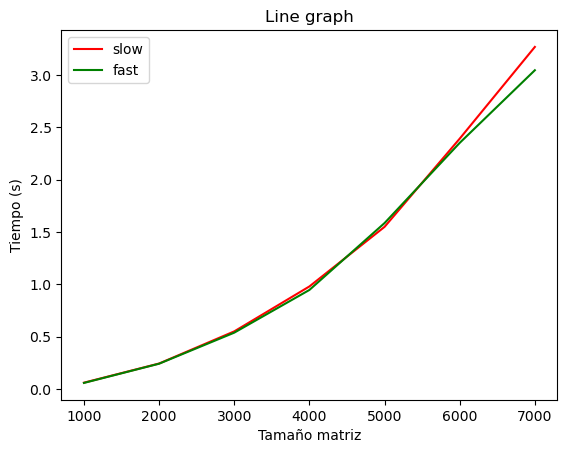

In [26]:
# Medimos los tiempos de ejecución de ambas funciones en Python
import matplotlib.pyplot as plt

x = []
y = []
z = []

for i in range(1000, 8000, 1000):
  
    matrix = np.random.rand(i, i)
    x.append(i)

    # Slow
    with Timer() as t:
      slow.py_func(matrix)
      
    result = t.interval
    
    print(f"Slow - Size {i} Time {result}")
    y.append(result)

    # Fast
    with Timer() as t:
      fast.py_func(matrix)
    
    result = t.interval
    
    print(f"Fast - Size {i} Time {result}")
    z.append(result)

# plotting
plt.title("Line graph")
plt.xlabel("Tamaño matriz")
plt.ylabel("Tiempo (s)")
plt.plot(x, y, color ="red", label="slow")
plt.plot(x, z, color ="green", label="fast")
plt.legend(loc="upper left")
plt.show()

## Pregunta 1
Como se puede observar, la función fast es más rápida ¿Cuál es la principal diferencia entre ambas funciones?

La única diferencia es en qué orden se accede a los elementos. En la función slow, se accede primero a las columnas y después a las filas. Por su parte, la función fast accede primero a las filas, pudiendo traer elementos contiguos en bloques de memoria. De esta forma, el procesador no necesita traer un bloque por cada operación de suma.  

## Ejercicio 1
Obten los resultados para las funciones compiladas con Numpy. Se recomienda realizar, para cada uno de los tamaños de matriz, al menos 5 repeticiones y obtener la media de esas ejecuciones como valor de tiempo.


In [27]:
# Medimos los tiempos de ejecución de ambas funciones en Python

# Se supone que las funciones ya están compiladas con Numpy por haberlas ejecutado antes 
# teniendo un decorador de Numba en su definición, así que tan solo habría que medir los 
# tiempos llamandolas sin el sufijo py_func. 

tamaño = []
tiempo_slow = []
tiempo_fast = []

n_iter = 20

for i in range(1000, 11000, 1000):
  
    matrix = np.random.rand(i, i)
    tamaño.append(i)

    # - - - - Slow - - - - 
    
    # 1. Creamos un array para almacenar 10 tiempos:
    results_slow = 0
  
    for _ in range(n_iter):
      
      # 2. Medimos el tiempo y lo guardamos en el array:
      
      with Timer() as t:
        slow(matrix)
      
      result = t.interval
      results_slow += result
    
    # 3. Calculamos la media de tiempos
      
    results_slow /= n_iter
      
    # 4. Lo añadimos a los tiempos de slow
    tiempo_slow.append(result)

    # - - - - Fast - - - - 
    
    # 1. Creamos un array para almacenar 10 tiempos:
    results_fast = 0
    
    for _ in range(n_iter):
      
      # 2. Medimos el tiempo y lo guardamos en el array:
      with Timer() as t:
        fast(matrix)
      
      result = t.interval  
      results_fast += result
    
    # 3. Calculamos la media de tiempos
      
    results_fast /= n_iter
      
    # 4. Lo añadimos a los tiempos de slow
    tiempo_fast.append(result)

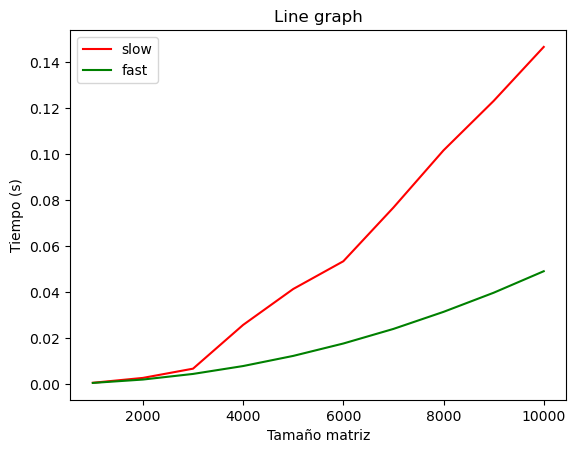

In [28]:
# Conviene visualizar los resultados:

plt.title("Line graph")
plt.xlabel("Tamaño matriz")
plt.ylabel("Tiempo (s)")
plt.plot(tamaño, tiempo_slow, color ="red", label="slow")
plt.plot(tamaño, tiempo_fast, color ="green", label="fast")
plt.legend(loc="upper left")
plt.show()

## Pregunta 2

¿Por qué para matrices pequeñas los tiempos de ejecución de ambas versiones son similares, pero se separan según aumenta el tamaño de la matriz?

Como se explicaba antes, la función slow tiene que traer a la caché muchos más bloques de la memoria RAM por acceder primero a columnas "aprovechando menos cada viaje". La diferencia entre traer 1000 y 2000 bloques es despreciable. No así la diferencia entre traer 1000 y 15000. De hecho, es probable que matrices tan grandes no quepan en caché, teniendo que ir a buscarlas directamente a la RAM, aumentando así, de forma tan exagerada, el tiempo para sumar los elementos al cruzar un tamaño arbitrario de matrices (como se observa en la imagen, que parece ser 3000 aproximadamente).

## Multiplicación de matrices

A continuación se muestra un código desarrollado para multiplicar dos matrices.

In [29]:
# Multiplicación de matrices lenta

@jit(nopython=True)
def matrix_multiplication_slow(A, B):
  m, n = A.shape
  _, p = B.shape
  C = np.zeros((m, p))
  for i in range(m):
    for k in range(p):
      for j in range(n):
        C[i, k] += A[i, j] * B[j, k]
  return C

matrix1 = np.random.rand(10, 10)
matrix2 = np.random.rand(10, 10)

# Se comprueba que el resultado es correcto
print(matrix1 @ matrix2)
print("")
print(matrix_multiplication_slow.py_func(matrix1, matrix2))
print("")
print(matrix_multiplication_slow(matrix1, matrix2))

[[2.63646271 2.42520631 2.67792288 2.1323102  1.64957124 1.73666269
  2.07448393 2.82507561 1.67091849 1.73645878]
 [3.61337396 3.25287176 3.53078535 3.0848218  2.37347263 2.97763549
  2.64830776 4.42168325 2.72669757 2.65431879]
 [2.68886605 2.38534574 3.19665217 2.78257681 1.85528314 1.9387286
  1.89002493 2.76340288 1.71280346 1.98196522]
 [3.55469947 3.10157831 3.80572519 2.68838185 2.03086506 2.58510237
  2.79293143 4.2450128  2.41136752 2.26100902]
 [2.87022642 2.57261421 2.30588119 2.31332945 2.1356053  2.14508424
  1.94478871 3.0403896  1.88398695 1.82297634]
 [2.42585475 2.3505818  3.08626624 2.24556705 1.6509824  1.99265714
  2.12046831 3.18240009 2.08182059 1.56470992]
 [3.06136999 2.52407103 3.18902393 2.29710923 2.08118243 2.26146228
  2.37717371 3.67743321 2.11543799 1.7821737 ]
 [2.70679073 1.89747875 2.69828255 2.06192665 1.34590083 2.43311626
  1.9144946  3.39664709 2.1089495  1.50341274]
 [2.99491592 2.81907539 3.31194882 2.60885079 2.17009134 2.53450692
  2.35761703 

In [30]:
# Comparar rendimiento
A = np.random.randn(200, 200)
B = np.random.randn(200, 200)

print('Python slow')
%timeit matrix_multiplication_slow.py_func(A, B)
print('Numba slow')
%timeit matrix_multiplication_slow(A, B)
print('numpy')
%timeit A @ B

Python slow
1.47 s ± 26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Numba slow
3.88 ms ± 56.6 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
numpy
195 μs ± 26.4 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Ejercicio 2

El código anterior es lento, incluso compilado con Numba. Desarrolle una versión más rápida haciendo uso de los conocimientos adquiridos en el ejercicio anterior.

In [31]:
# Multiplicación de matrices rápida
@jit(nopython=True)
def matrix_multiplication_fast(A, B):
  m, n = A.shape
  q, p = B.shape
  C = np.zeros((m, p))
  for i in range(m): # Primero filas de A 
    for j in range(n): # Luego columnas de A 
      for k in range(q): # Luego filas de B
        C[i, k] += A[i, j] * B[j, k]
  return C

In [32]:
# Comparar rendimiento
A = np.random.randn(200, 200)
B = np.random.randn(200, 200)

print('Python fast')
%timeit matrix_multiplication_fast.py_func(A, B)
print('Numba fast')
%timeit matrix_multiplication_fast(A, B)
print('numpy')
%timeit A @ B

Python fast
1.46 s ± 25.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Numba fast
992 μs ± 244 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
numpy
217 μs ± 32.9 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Es claro que la mejora en rendimiento para la versión compilada es un x3 aproximadamente. Aunque la versión sin compilar sigue siendo igual de lenta, puesto que el 95% del tiempo se la pasa llamando al intérprete, por lo que encontrar una mejoría era altamente improbable. 

## Ejercicio 3

Compare los tiempos de ejecución, para ambas versiones de la multiplicación de matrices, para tamaños de matrices de 1000 a 2000 con saltos de 100.

Nota: Dado que los tiempos son razonablemente altos, obtener la media de repeticiones es opcional.

In [33]:
# Medimos los tiempos de ejecución de ambas funciones de multiplicaciones de matrices en Python

# Podemos reciclar casi todo el código de antes:

tamaño = []
tiempo_slow = []
tiempo_fast = []

n_iter = 2

for i in range(1000, 2000, 100):
  
    matrix1 = np.random.rand(i, i)
    matrix2 = np.random.rand(i, i)
    tamaño.append(i)

    # - - - - Matrix Mult Slow - - - - 
    
    # 1. Creamos un array para almacenar 10 tiempos:
    results_slow = 0
  
    for _ in range(n_iter):
      
      # 2. Medimos el tiempo y lo guardamos en el array:
      
      with Timer() as t:
        matrix_multiplication_slow(matrix1, matrix2)
      
      result = t.interval
      results_slow += result
    
    # 3. Calculamos la media de tiempos
      
    results_slow /= n_iter
      
    # 4. Lo añadimos a los tiempos de slow
    tiempo_slow.append(result)

    # - - - - Matrix Mult Fast - - - - 
    
    # 1. Creamos un array para almacenar 10 tiempos:
    results_fast = 0
    
    for _ in range(n_iter):
      
      # 2. Medimos el tiempo y lo guardamos en el array:
      with Timer() as t:
        matrix_multiplication_fast(matrix1, matrix2)
      
      result = t.interval  
      results_fast += result
    
    # 3. Calculamos la media de tiempos
      
    results_fast /= n_iter
      
    # 4. Lo añadimos a los tiempos de slow
    tiempo_fast.append(result)

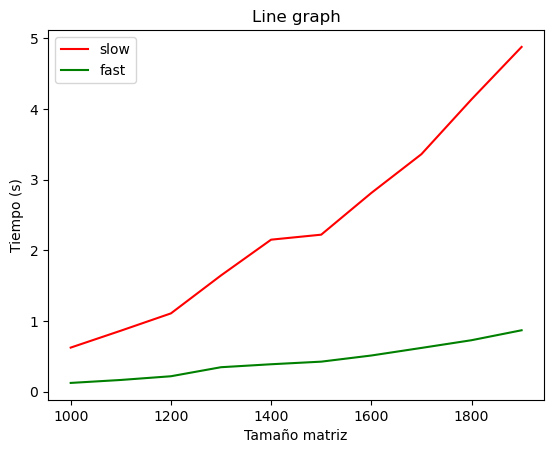

In [34]:
plt.title("Line graph")
plt.xlabel("Tamaño matriz")
plt.ylabel("Tiempo (s)")
plt.plot(tamaño, tiempo_slow, color ="red", label="slow")
plt.plot(tamaño, tiempo_fast, color ="green", label="fast")
plt.legend(loc="upper left")
plt.show()

## Pregunta 3
Justifique el efecto observado. ¿Se observan cambios de tendencia al variar los tamaños de las matrices? ¿A qué se deben?

La función fast casi parece lineal con respecto al tiempo para tamaños tan pequeños (es cúbica en realidad). Por su parte, slow nota en mucha mayor medida un aumento de tamaño a pesar de ser en realidad un algoritmo con igual coste en tiempo ($O(N^3)$). 

Por supuesto que se nota un cambio de tendencia. No se debe a la vectorización SIMD, pues ambas funciones juegan con la misma ventaja en ese sentido. Se debe a las mismas razones que exponíamos antes en el ejercicio 3. La función fast es capaz de traer bloques de memoria más eficientemente aprovechando en mayor medida cada bloque traído. Esto permite traer muchos menos bloques para hacer la misma operación y por tanto reducir drásticamente el tiempo de ejecución. 

## Ejercicio 4

Utilizando la versión más rápida de la multiplicación de matrices implementada con Numba, se pide analizar la paralelización de cada uno de los tres bucles de la multiplicación matricial clásica.

Cree tres versiones diferentes de la función de multiplicación, cada una paralelizando únicamente uno de los bucles mediante prange, es decir:

* Versión A: paralelizar el bucle exterior
* Versión B: paralelizar el bucle intermedio
* Versión C: paralelizar el bucle interior

El objetivo es determinar qué bucle es más adecuado para la paralelización.

En Numba, el número de hilos a utilizar puede configurarse mediante la función
Python "numba.set_num_threads(n)"

Para cada una de las tres versiones (A, B y C), y para un número de hilos que vaya desde 1 hasta el número máximo de núcleos disponibles (máximo 4):

* Mida el tiempo de multiplicar matrices cuadradas cuyos tamaños vayan desde 1000 hasta 2000, con incrementos de 200.
* Genere una gráfica independiente para cada valor del número de hilos (es decir, una gráfica para 1 hilo, otra para 2 hilos, etc.). En cada gráfica deben aparecer las tres versiones (A, B, C), comparando sus tiempos.

El resultado debe permitir visualizar qué bucle se beneficia más de la paralelización y cómo influye el número de hilos en el rendimiento.

In [35]:
# Multiplicación de matrices A
@jit(nopython=True, parallel=True)
def matrix_multiplication_fast_A(A, B):
  m, n = A.shape
  q, p = B.shape
  C = np.zeros((m, p))
  for i in numba.prange(m): # Paralelizamos el primer bucle
    for j in range(n): 
      for k in range(q):
        C[i, k] += A[i, j] * B[j, k]
  return C

  # Multiplicación de matrices B
@jit(nopython=True, parallel=True)
def matrix_multiplication_fast_B(A, B):
  m, n = A.shape
  q, p = B.shape
  C = np.zeros((m, p))
  for i in range(m):
    for j in numba.prange(n): # Paralelizamos el segundo bucle
      for k in range(q):
        C[i, k] += A[i, j] * B[j, k]
  return C

  # Multiplicación de matrices C
@jit(nopython=True, parallel=True)
def matrix_multiplication_fast_C(A, B):
  m, n = A.shape
  q, p = B.shape
  C = np.zeros((m, p))
  for i in range(m):
    for j in range(n): 
      for k in numba.prange(q): # Paralelizamos el tercer bucle
        C[i, k] += A[i, j] * B[j, k]
  return C

In [36]:
# Medimos los tiempos de ejecución de las 3 funciones de multiplicaciones de matrices en Python

# Podemos volver a reciclar casi todo el código de antes:

tamaño = []
tiempo_fast_A = []
tiempo_fast_B = []
tiempo_fast_C = []

n_iter = 1

for i in range(1000, 2000, 100):
  
    matrix1 = np.random.rand(i, i)
    matrix2 = np.random.rand(i, i)
    tamaño.append(i)

    # - - - - Matrix Mult A - - - - 
    
    # 1. Creamos un array para almacenar 10 tiempos:
    results_fast_A = 0
  
    for _ in range(n_iter):
      
      # 2. Medimos el tiempo y lo guardamos en el array:
      
      with Timer() as t:
        matrix_multiplication_fast_A(matrix1, matrix2)
      
      result = t.interval
      results_fast_A += result
    
    # 3. Calculamos la media de tiempos
      
    results_fast_A /= n_iter
      
    # 4. Lo añadimos a los tiempos de slow
    tiempo_fast_A.append(result)

    # - - - - Matrix Mult B - - - - 
    
    # 1. Creamos un array para almacenar 10 tiempos:
    results_fast_B = 0
  
    for _ in range(n_iter):
      
      # 2. Medimos el tiempo y lo guardamos en el array:
      
      with Timer() as t:
        matrix_multiplication_fast_B(matrix1, matrix2)
      
      result = t.interval
      results_fast_B += result
    
    # 3. Calculamos la media de tiempos
      
    results_fast_B /= n_iter
      
    # 4. Lo añadimos a los tiempos de slow
    tiempo_fast_B.append(result)
    
    # - - - - Matrix Mult C - - - - 
    
    # 1. Creamos un array para almacenar 10 tiempos:
    results_fast_C = 0
  
    for _ in range(n_iter):
      
      # 2. Medimos el tiempo y lo guardamos en el array:
      
      with Timer() as t:
        matrix_multiplication_fast_C(matrix1, matrix2)
      
      result = t.interval
      results_fast_C += result
    
    # 3. Calculamos la media de tiempos
      
    results_fast_C /= n_iter
      
    # 4. Lo añadimos a los tiempos de slow
    tiempo_fast_C.append(result)

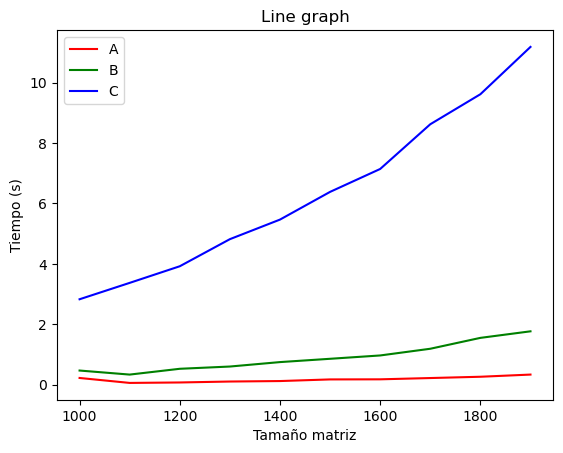

In [37]:
plt.title("Line graph")
plt.xlabel("Tamaño matriz")
plt.ylabel("Tiempo (s)")
plt.plot(tamaño, tiempo_fast_A, color ="red", label="A")
plt.plot(tamaño, tiempo_fast_B, color ="green", label="B")
plt.plot(tamaño, tiempo_fast_C, color ="blue", label="C")
plt.legend(loc="upper left")
plt.show()

La máquina desde la que se va a ejecutar el programa tiene 10 núcleos, es decir, podríamos crear hasta 10 hilos que se ejecutarían de forma completamente paralela. Sin embargo, parece que se ha fijado a 4 el máximo de hilos, por lo que solo tendremos un tal número de hilos, como máximo. A continuación, se presentarán 3 gráficas distintas, una para cada paralelización de bucle: $\{A, B, C\}$, con 4 curvas: una para cada número de hilos. 

Lo más sencillo es reutilizar código para escribir una función mediante dibujar cada uno de los subplots. 

In [ ]:
from typing import Callable, int

def compare_num_threads(func: Callable, n_iter: int):
    
    tamaño = []
    tiempo_1_hilo = []
    tiempo_2_hilos = []
    tiempo_3_hilos = []
    tiempo_4_hilos = []

    n_iter = 1

    for i in range(1000, 2000, 100):
    
        matrix1 = np.random.rand(i, i)
        matrix2 = np.random.rand(i, i)
        tamaño.append(i)

        # - - - - Matrix Mult 1 Hilo - - - - 
        
        # 0. Fijamos a 1 el número de hilos:
        
        numba.set_num_threads(1)
        
        # 1. Creamos un array para almacenar 10 tiempos:
        results_1_hilo = 0
    
        for _ in range(n_iter):
        
        # 2. Medimos el tiempo y lo guardamos en el array:
        
            with Timer() as t:
                func(matrix1, matrix2)
        
            result = t.interval
            results_1_hilo += result
        
        # 3. Calculamos la media de tiempos
        
        results_1_hilo /= n_iter
        
        # 4. Lo añadimos a los tiempos de slow
        tiempo_1_hilo.append(result)

        # - - - - Matrix Mult 2 Hilos - - - - 
        
        # 0. Fijamos a 2 el número de hilos:
        
        numba.set_num_threads(2)
        
        # 1. Creamos un array para almacenar 10 tiempos:
        results_2_hilos = 0
    
        for _ in range(n_iter):
        
        # 2. Medimos el tiempo y lo guardamos en el array:
        
            with Timer() as t:
                func(matrix1, matrix2)
        
            result = t.interval
            results_2_hilos += result
        
        # 3. Calculamos la media de tiempos
        
        results_2_hilos /= n_iter
        
        # 4. Lo añadimos a los tiempos de slow
        tiempo_2_hilos.append(result)
        
        # - - - - Matrix Mult 3 Hilos - - - - 
        
        # 0. Fijamos a 3 el número de hilos:
        
        numba.set_num_threads(3)
        
        # 1. Creamos un array para almacenar 10 tiempos:
        results_3_hilos = 0
    
        for _ in range(n_iter):
        
        # 2. Medimos el tiempo y lo guardamos en el array:
        
            with Timer() as t:
                func(matrix1, matrix2)
            
            result = t.interval
            results_3_hilos += result
        
        # 3. Calculamos la media de tiempos
        
        results_3_hilos /= n_iter
        
        # 4. Lo añadimos a los tiempos de slow
        tiempo_3_hilos.append(result)
        
        # - - - - Matrix Mult 4 Hilos - - - - 
        
        # 0. Fijamos a 4 el número de hilos:
        
        numba.set_num_threads(4)
        
        # 1. Creamos un array para almacenar 10 tiempos:
        results_4_hilos = 0
    
        for _ in range(n_iter):
        
        # 2. Medimos el tiempo y lo guardamos en el array:
        
            with Timer() as t:
                func(matrix1, matrix2)
            
            result = t.interval
            results_4_hilos += result
        
        # 3. Calculamos la media de tiempos
        
        results_4_hilos /= n_iter
        
        # 4. Lo añadimos a los tiempos de slow
        tiempo_4_hilos.append(result)

    plt.title(f"{func.__name__}")
    plt.xlabel("Tamaño matriz")
    plt.ylabel("Tiempo (s)")
    plt.plot(tamaño, tiempo_1_hilo, color ="red", label="1 Hilo")
    plt.plot(tamaño, tiempo_2_hilos, color ="green", label="2 Hilos")
    plt.plot(tamaño, tiempo_3_hilos, color ="yellow", label="3 Hilos")
    plt.plot(tamaño, tiempo_4_hilos, color ="blue", label="4 Hilos")
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

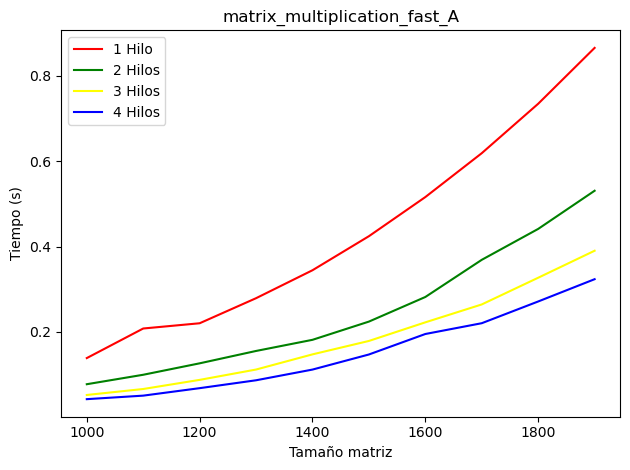

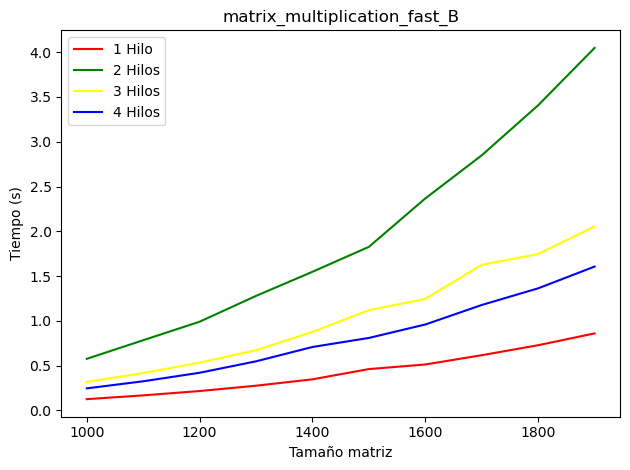

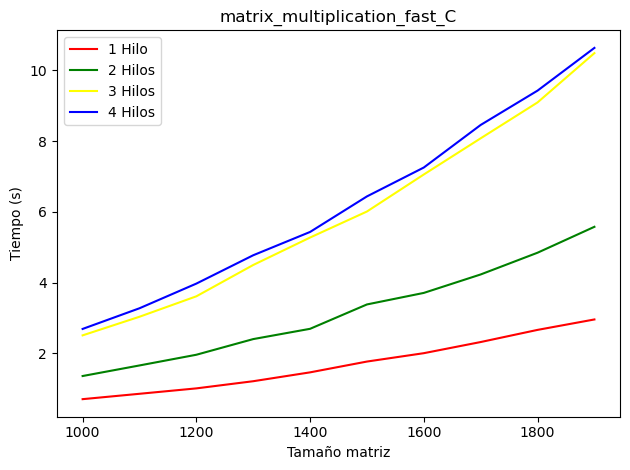

In [39]:
import matplotlib.pyplot as plt

plt.figure()
compare_num_threads(matrix_multiplication_fast_A, 2)

plt.figure()
compare_num_threads(matrix_multiplication_fast_B, 1)

plt.figure()
compare_num_threads(matrix_multiplication_fast_C, 1)

## Pregunta 4
¿Cuál de los tres bucles resulta más adecuado para aplicar paralelización en la multiplicación de matrices? Explique y justifique su respuesta basándose en los resultados obtenidos y en las características del algoritmo.

Es evidente que la mejor paralelización es la primera, la A, en la que se paraleliza el primer bucle. Cuanto más externo sea el bucle, mayor número de operaciones acaparas al paralelizar creando "tareas globales más grandes y pesadas". Técnicamente es más fácil de paralelizar 8 operaciones grandes que 8 millones de operaciones unitarias (al menos si lo vas a ejecutar usando CPU), pues sigues teniendo ese x4 en rendimiento, pero creando solo 8 hilos, no 8 millones. Por tanto, es lógico pensar que paralelizar el primer bucle es la mejor alternativa, pues no excluyes de la paralelización a ninguna operación. 

En cuanto a la paralelización: parece lógico valorar la calidad de una paralelización en función de lo mucho que se puede aprovechar en comparación con otras paralelizaciones. Así, una buena paralelización tiene que alcanzar su rendimiento máximo cuando se ejecuta con un número máximo de procesadores. Este efecto puede observarse comparando las distintas paralelizaciones:

- Al paralelizar el primer bucle, el mejor de los rendimientos se obtiene cuando se ejecuta con 4 hilos. 
- Al paralelizar el segundo bucle, el mejor rendimiento se obtiene cuando se ejecuta con 1 hilo. Esto parece estar mal, pues la máquina tarda menos en ejecutar con 3 procesadores menos. Claramente no se aprovecha la potencia de cada procesador. 
- Al paralelizar el tercer bucle, todo parece el mundo al revés. Cuantos más procesadores peor. Esto carece de sentido, el rendimiento parece ser inverso a la capacidad de cómputo. 

Por tanto, podemos concluir que la paralelización del primer bucle también es mejor en este sentido: permite aprovechar mejor la potencia de la máquina desde la que se ejecuta. 